In [126]:
import sys
!python -m pip install sentencepiece

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import sentencepiece as spm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

## Load the module from TF-Hub

In [9]:
module = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-lite/2")

In [10]:
input_placeholder = tf.sparse_placeholder(tf.int64, shape=[None, None])
encodings = module(
    inputs=dict(
        values=input_placeholder.values,
        indices=input_placeholder.indices,
        dense_shape=input_placeholder.dense_shape))

In [11]:
with tf.Session() as sess:
    spm_path = sess.run(module(signature="spm_path"))

sp = spm.SentencePieceProcessor()
sp.Load(spm_path)
print("SentencePiece model loaded at {}.".format(spm_path))

SentencePiece model loaded at /var/folders/ln/vmp0v5ps277_b7pymr9bpdb40000gn/T/tfhub_modules/539544f0a997d91c327c23285ea00c37588d92cc/assets/universal_encoder_8k_spm.model.


In [12]:
def process_to_IDs_in_sparse_format(sp, sentences):
  # An utility method that processes sentences with the sentence piece processor
  # 'sp' and returns the results in tf.SparseTensor-similar format:
  # (values, indices, dense_shape)
  ids = [sp.EncodeAsIds(x) for x in sentences]
  max_len = max(len(x) for x in ids)
  dense_shape=(len(ids), max_len)
  values=[item for sublist in ids for item in sublist]
  indices=[[row,col] for row in range(len(ids)) for col in range(len(ids[row]))]
  return (values, indices, dense_shape)

### Test the module with a few examples

In [105]:
sample="I was in a car with my mother up near the Plantageants' house. There was some kind of problem with the car, and I could hear a noise that was not quite normal. The wife was driving, and told me to turn the key in the ignition backward and that should fix the problem. Then, probably not as a direct result of turning the key, the car went flying off the side of the road staying on its wheels and managing not to hit anything, coming very close to driving into a pond. This next scene seems like it took place in about the same place. I think I have built a saddle for my pony, and I need help, maybe getting the saddle on. I'm in somebody's yard, apparently someone who has a lot of horses and animals of their own. The owners are a Ukrainian woman and her husband, as I soon learn. She does not want to come and look at my pony to answer the question. She says to me, If you consider selling it to me, I'll have to come and look at it, so I told her I would consider it. The next thing I remember, I am in the woman's house with a guinea pig. She tells me that people in certain parts of the world eat guinea pigs. She said that with such calmness and matter. of. factness I supposed she would not be one to blink her eyes if she saw someone trying to put a poor animal on the frying pan. Actually, I would not really have been surprised if guinea pig was her favorite meal. I obviously did not let her get close to my pig."
from nltk import sent_tokenize
sents= sent_tokenize(sample)
print len(sents)

17


In [90]:
sents

['Heard a mother talking to a child.',
 'She came with a two year old.',
 'I asked him about his bath and showed him my large doll with very long clothes.',
 'Turned up its skirts so he could see its feet.',
 'He was playing with toys about the large room.',
 'I suggest him building a block track for his train.',
 'He goes to get the long blocks to build the track.']

In [7]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(session, input_placeholder, messages):
    values, indices, dense_shape = process_to_IDs_in_sparse_format(sp,messages)

    message_embeddings = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})
  
    plot_similarity(messages, message_embeddings, 90)

In [109]:
n=len(message_embeddings)
for i in range(n-1):
    message_embeddings=np.append(message_embeddings,[(message_embeddings[i]+message_embeddings[i+1])/2],axis=0)
for i in range(n-2):
    message_embeddings=np.append(message_embeddings,[(message_embeddings[i]+message_embeddings[i+1]+message_embeddings[i+2])/3],axis=0)                           

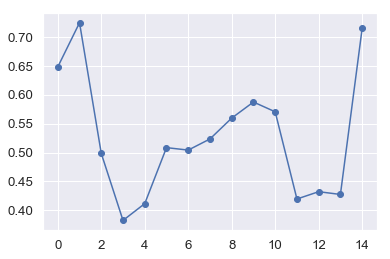

In [110]:
corre=[]
# print sents
for i in range(n-2):
    corre.append(np.inner(message_embeddings[i+n],message_embeddings[i+1+n]))
plt.plot(corre,'o-')


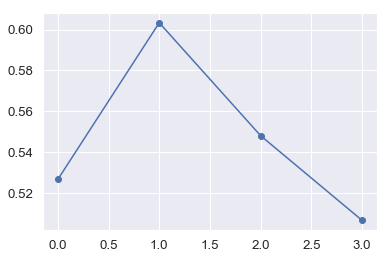

In [95]:
corre=[]
# print sents
for i in range(n-3):
    corre.append(np.inner(message_embeddings[i+2*n-1],message_embeddings[i+1+2*n-1]))
plt.plot(corre,'o-')

('k: ', 1)
('k: ', 2)
('k: ', 3)
('k: ', 4)
('k: ', 5)
('k: ', 6)
('k: ', 7)
('k: ', 8)
('k: ', 9)
('k: ', 10)
('k: ', 11)
('k: ', 12)
('k: ', 13)
('k: ', 14)
('k: ', 15)
('k: ', 16)
('k: ', 17)
('k: ', 18)
('k: ', 19)


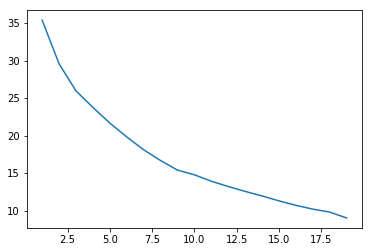

In [37]:
# Elbow criterion
from sklearn.cluster import KMeans
def elbow_plot(data, maxK=10, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = {}
    for k in range(1, maxK):
        print("k: ", k)
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
#             data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
#             data["clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.show()
    return

elbow_plot(message_embeddings, maxK=20)

## Similarity visualized
Here we show the similarity in a heat map. The final graph is a 9x9 matrix where each entry `[i, j]` is colored based on the inner product of the encodings for sentence `i` and `j`.

In [12]:
#messages = ["bag","Washington","City","where is this"]
messages = ["A policeman halts an oncoming car", 
            "these 2 cops Then somehow are driving the car",
            "They parked they car",
            "I was driving my car",
            "they told me to do this",
            "I said I won't do anything"
            
           ]

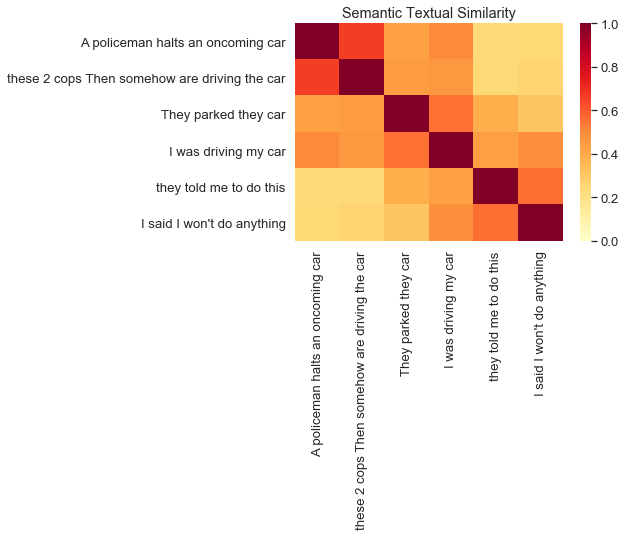

In [13]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, input_placeholder, messages)

In [101]:
print t_annotated['ner']

[('I', 'O'), ('went', 'O'), ('to', 'O'), ('Germany', 'S-LOC')]


# Find Places

In [ ]:
import csv
places=[]
f = open('places.csv', 'rb')
reader = csv.reader(f)
for row in reader:
    places.append(row[0])
f.close()
tf.logging.set_verbosity(tf.logging.ERROR)
embeddings_places=[]
messages = places
values, indices, dense_shape = process_to_IDs_in_sparse_format(sp, messages)

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    place_embeddings = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})

In [95]:
print places

['\xef\xbb\xbfsnowy road ', 'highway ', 'beach ', 'land ', 'structure', 'bridge', 'side', 'neighborhood', 'rock place', 'somewhere', 'path', 'rolling hills', 'fields', 'Valley', 'street', 'road', 'tunnel', 'escalator', 'hotel', 'room', 'city', 'desert', 'destination', 'aiplane', 'adventure', 'cabin', 'cabin camping', 'spaceship', 'spacecraft', 'downtown', 'country', 'desert', 'resort', 'bin', 'train', 'elevator', 'tower', 'house', 'outside', 'area', 'space', 'coast', 'town', 'field', 'forest', 'boat', 'ocean', 'restaurant', 'place', 'hallway', 'river', 'airport', 'terminal', 'region', 'motel', 'way', 'wilderness', 'camp', 'mountain', 'home', 'cave', 'station', 'airport', 'freeway', 'tram', 'coast']


In [96]:
print np.inner(place_embeddings[0],place_embeddings[0])

1.0


In [2]:
def findPssibleLocation(t_orig,place_embeddings):
    t_sentences = sent_tokenize(t_orig)
    result=[]
    for t_ind, t in enumerate(t_sentences):
        t_annotated = annotator.getAnnotations(t, dep_parse=True)
        ner=t_annotated['ner']
        for p1,p2 in ner:
            if p2=='S-LOC':
                result.append(p1)
    words=t_annotated['words']
    values, indices, dense_shape = process_to_IDs_in_sparse_format(sp, words)
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        word_embeddings = session.run(
          encodings,
          feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})
    j=-1
    while j<len(word_embeddings)-1:
        j=j+1
        for i in range(len(place_embeddings)):
            
            if np.inner(place_embeddings[i],word_embeddings[j])>0.75:
                result.append(words[j])
                j=j+1
                if j>len(word_embeddings)-1:
                    break
    return result

In [118]:
t="I have gone on a tour bus to Mexico for a few days"
t="I am in a small town with Patricia and Charla."
t="I came across a park for meeting in afternoon"
t="We are visiting a strange house, I am angry at Frank for flirting with a young woman"
#t="The park feels like it is in Washington"
print findPssibleLocation(t,place_embeddings)

['house']


In [120]:
# t="I dreamed I had to go on a long ocean voyage and I was in uniform of some branch of the military forces."
# t="The culture here was Asian, and the place I was staying, martial arts predominated as a pastime."
# t="We are outside"
# t="I'm driving down snowy road "
# t="I'm on a log flume ride "
# t="The park feels like it is in Washington."
t="I came across a park for meeting in afternoon"
t_annotated = annotator.getAnnotations(t, dep_parse=True)
dep_parsing = t_annotated["dep_parse"]
list_words=dep_parsing.split('\n')
o_word=[]
for p in list_words:
#     p=str(p)
#     p.replace('\n',' ')
    p=p.replace(')',' ')
    p=p.replace('(',' ')
    l_p=p.split(' ')
    if 'prep'in l_p[0]:
        res=l_p[2].split('-')
        o_word.append(res[0])
        print res[0]
        print l_p[0],l_p[1],l_p[2]

park
prep_across came-2, park-5
meeting
prep_for came-2, meeting-7
afternoon
prep_in meeting-7, afternoon-9


In [115]:
words=o_word
words
values, indices, dense_shape = process_to_IDs_in_sparse_format(sp, words)
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    word_embeddings = session.run(
        encodings,
        feed_dict={input_placeholder.values: values,
            input_placeholder.indices: indices,
            input_placeholder.dense_shape: dense_shape})
j=-1
while j<len(word_embeddings)-1:
    j=j+1
    th=0
    index=0
    for i in range(len(place_embeddings)):
        th_temp=np.inner(place_embeddings[i],word_embeddings[j])
        if th_temp>th:
            index=i
            th=th_temp
    print "original word ",o_word[j]
    print places[index]
    print th
    

original word  park
street
0.7203883
original word  meeting
resort
0.54441565
original word  afternoon
home
0.5467155
